In [1]:
import numpy as np
import csv
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import random
from scipy.optimize import check_grad
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
import numdifftools as nd
import collections
import pickle as pkl
from sklearn.calibration import CalibratedClassifierCV
import matplotlib
import warnings
import itertools
from scipy.stats.stats import pearsonr
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import normalized_mutual_info_score

In [ ]:
#name of file to store generated data
data__file = '../../data/semi_synthetic/Data_semisynthetic_v1.pkl'

# Load data

### Preprocess data

In [2]:
with open('../../data/ChildWelfare/X_preprocess.pkl', 'rb') as handle:
    X, screener_ids, refer_ids, Y_observed, Y_human, Y_serv, Y_sub, colnames = pkl.load(handle)

In [3]:
dat_sorted = pd.read_csv("../../data/ChildWelfare/child_welfare_with_call.csv")
dat_sorted = dat_sorted.sort_values(['REFER_DT'])
dat_sorted.drop_duplicates(subset=['MCI_ID'],inplace=True)

In [4]:
df_count = (dat_sorted[colnames]!=0).sum(axis=0)
(pd.DataFrame(df_count)).sort_values(by=0,ascending=False)[0:70]

,0
VIC_COUNT_NULL,46544
POVERYRATE_NULL,45516
PERP_COUNT_NULL,43476
AGE_AT_RFRL_VICT_SELF,40268
NO_BH_VICT_SELF,37683
...,...
DAYS_LAST_SEEN_IN_BH_CHLD,3906
PRNT_AGE_2024_NULL,3473
VIC_OTHER_NULL,3441
DPW_SSI_3_CHLD,3362


### Select business rule for positivity assumption violation (D_0), omitted outcome Y_2, and bias feature

In [5]:
#Sensitive attribute
D_0_name = 'DPW_SSI_EVERIN_PRNT' #'VIC_AGE_TEEN_NULL'
D_0 = np.array((dat_sorted['DPW_SSI_EVERIN_PRNT']!=0))
#omitted outcome in Y
Y_2_name = 'DAYS_FROM_LASTRFRL_PERP'
Y_2 = np.array((dat_sorted['DAYS_FROM_LASTRFRL_PERP']!=0))
biasfeat_name = 'TOTAL_C_19_PERP'
biasfeat = (dat_sorted['TOTAL_C_19_PERP']!=0)

In [6]:
X = np.delete(X,np.where(colnames=='TOTAL_C_19_PERP')[0][0],1)

In [7]:
scaler = sklearn.preprocessing.StandardScaler()
X = np.column_stack((X, np.array(biasfeat)[:,np.newaxis]))
X = np.hstack((X, np.ones((X.shape[0],1))))
X = scaler.fit_transform(X)

In [8]:
#colnames
X.shape

(46544, 217)

### Create semi-synthetic labels Y1, Y2, Y using logit models

/zfsauton/home/mdeartea/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7913285161634696
44


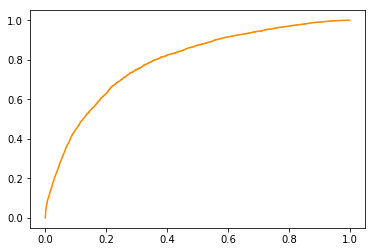

In [14]:
#Fit model to predict observed Y
logit = linear_model.LogisticRegression(penalty = 'l1', C=0.005, random_state=42, fit_intercept=False)
clf = logit.fit(X, Y_observed)
Y_pred = clf.predict_proba(X)
fpr, tpr,thres = sklearn.metrics.roc_curve(Y_observed, Y_pred[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
print(roc_auc)
coef_pred_y = clf.coef_
print(sum(coef_pred_y[0]!=0))
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)

In [15]:
#Sample coefficients centered around the fitted coefficients
def resample_coef(coef_pred_y):
    for i in np.arange(len(coef_pred_y)):
        if coef_pred_y[i]!=0:
            np.random.seed(seed=0)
            c_new = np.random.normal(loc = coef_pred_y[i],scale=1.0)
            coef_pred_y[i] = c_new
    coef_pred_y[-2] = 0
    return coef_pred_y


In [16]:
def f_label(x,coef):
    z=np.dot(x,coef)
    pr = 1/(1+np.exp(-z))
    y = np.zeros(shape=pr.shape)
    for i in np.arange(pr.shape[0]):
        np.random.seed(seed=None)
        y[i] = np.random.binomial(1,pr[i])
    return y

In [17]:
#Resample coefficients and use this to generate synthetic Y_1
y1_coef=resample_coef(coef_pred_y[0])
Y_1 = f_label(X, y1_coef)

In [18]:
np.array(Y_2)[117]

True

In [9]:
#Synthetic Y_1 is union of Y_1 and Y_2

In [19]:
Y = np.array([max(Y_1[i],Y_2[i]) for i in np.arange(len(Y_1))])

In [20]:
print("Number of Y1 = 1: ", sum(Y_1))
print("Number of Y2 = 1: ", sum(Y_2))
print("Number of Y = 1: ", sum(Y))
print("Portion of Y_2=1 for which Y_1=1 ", sum(np.array(Y_1)[Y_2])/np.float(sum(Y_2)))

Number of Y1 = 1:  20524.0
Number of Y2 = 1:  13762
Number of Y = 1:  25285.0
Portion of Y_2=1 for which Y_1=1  0.6540473768347624


In [21]:
print('Mutual info Y_1, Y_2: ',normalized_mutual_info_score(Y_1,Y_2))
print('Mutual info Y_1, Y: ',normalized_mutual_info_score(Y_1,Y))
print('Mutual info Y_2, Y: ',normalized_mutual_info_score(Y_2,Y))

Mutual info Y_1, Y_2:  0.060131448925003314
Mutual info Y_1, Y:  0.6155591638473489
Mutual info Y_2, Y:  0.3597331254373652


In [22]:
#Check labels for individuals for whom the 'bias' indicator is on
print(sum(Y_1[np.array(dat_sorted['TOTAL_C_19_PERP']!=0)])/sum(dat_sorted['TOTAL_C_19_PERP']!=0))
print(sum(Y_2[np.array(dat_sorted['TOTAL_C_19_PERP']!=0)])/sum(dat_sorted['TOTAL_C_19_PERP']!=0))
print(sum(Y[np.array(dat_sorted['TOTAL_C_19_PERP']!=0)])/sum(dat_sorted['TOTAL_C_19_PERP']!=0))

0.5870906502135738
0.44803037494067394
0.7351684859990508


### Extract coefficients that will be used to create semi-synthetic human label D

0.9831514869441283


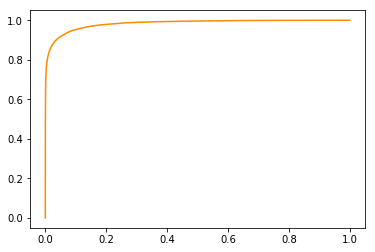

In [23]:
#build model to predict y1, we should be able to recover it almost perfectly
#add noise (sampler from a distribution defined for each decision maker)
logit = linear_model.LogisticRegression(penalty = 'l1', C=0.01, random_state=42, fit_intercept=False)
clf = logit.fit(X, Y)
Y_pred = clf.predict_proba(X)
fpr, tpr,thres = sklearn.metrics.roc_curve(Y, Y_pred[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
print(roc_auc)
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)

In [24]:
coef_pred_y = clf.coef_
sum(coef_pred_y[0]!=0)

86

## Pickle data 

In [26]:
# with open('../../data/semi_synthetic/X.pkl', 'wb') as file:
#     pkl.dump(X,file)
with open(data_file, 'wb') as file:
    pkl.dump([X,Y_1,Y_2,Y,D_0,refer_ids,screener_ids,coef_pred_y],file)

In [21]:
# with open('../../data/semi_synthetic/labels.pkl', 'rb') as handle:
#     b = pkl.load(handle)